**EE4685 Assignment 2: Building a miniGPT** by Josephine King and Alec Daalman

**References:**
- "Let's build GPT: from scratch, in code, spelled out." Youtube tutorial by Andrej Karpathy. https://www.youtube.com/watch?v=kCc8FmEb1nY
- HuggingFace Tokenizer developer guides. https://huggingface.co/docs/transformers/en/notebooks


In [ ]:
# Import packages
import os
from tqdm.notebook import tqdm
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
from tokenizers import Tokenizer, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt

# Setup
torch.manual_seed(6250513)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_PATH = "./saved_models/"
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# Initialize model parameters
TRAIN_PCT = 0.8
BLOCK_SIZE = 64
BATCH_SIZE = 32
MAX_ITER = 6000
VOCAB_SIZE = 3000
EMBD_DIM = 192
LR = 2.5e-5

# Download the TinyShakespeare dataset
!wget -O tinyshakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f: raw_data = f.read()


Using device cpu
--2025-03-22 14:08:29--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tinyshakespeare.txt’

tinyshakespeare.txt 100%[===================>]   1.06M  6.50MB/s    in 0.2s    

2025-03-22 14:08:29 (6.50 MB/s) - ‘tinyshakespeare.txt’ saved [1115394/1115394]



**Model Training Functions:**

In [168]:
def get_batch(data, batch_size, block_size):
    # Choose batch_size random starting points
    block_starts = torch.randint(0, len(data) - block_size, (batch_size,))
    # Get the inputs and outputs for the chosen blocks, stack them into tensors
    batch_inputs = torch.stack([data[start: start + block_size] for start in block_starts])
    batch_outputs = torch.stack([data[start + 1: start + block_size + 1] for start in block_starts])
    return batch_inputs, batch_outputs

def estimate_loss(model, data, batch_size, block_size, iters):
    out = {}
    model.eval()
    losses = torch.zeros(iters)
    for k in range(iters):
        inputs, outputs = get_batch(data, batch_size, block_size)
        logits, loss = model(inputs, outputs)
        losses[k] = loss.item()
    mean_loss = losses.mean()
    model.train()
    return mean_loss

# The following functions are copied/modified from the optimization exercise 
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(train_set, validation_set, model, model_name, optimizer, max_iter=1000, batch_size=256, block_size=32, overwrite=False, save_model=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        train_set - Training dataset
        model - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_iter - Number of iterations we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        ############
        # Training #
        ############
        model.train()
        training_losses = []
        validation_losses = []
        iters = []
        for iter in range(max_iter):
            inputs, outputs = get_batch(train_set, batch_size, block_size)
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            preds,loss = model(inputs, outputs)
            if iter % 100 == 0 or iter == max_iter - 1:
                print(f"iter {iter}: loss = {loss}")
                train_loss = estimate_loss(model, train_set, batch_size, block_size, 500)
                validation_loss = estimate_loss(model, validation_set, batch_size, block_size, 500)
                training_losses.append(train_loss)
                validation_losses.append(validation_loss)
                iters.append(iter)
                print(f"estimated train loss: {train_loss}, estimated validation loss: {validation_loss}")
            loss.backward()
            optimizer.step()

        if (save_model):
            save_model(model, CHECKPOINT_PATH, model_name)

    return model, training_losses, validation_losses, iters

**Bigram Language Model**

In [162]:
# Copied from Karpathy's tutorial
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Generate num_gen_tokens more tokens given the current tokens in curr_tokens
    def generate(self, curr_tokens, num_gen_tokens):
        for _ in range(num_gen_tokens):
            # Get the predictions for the next tokens 
            preds, loss = self.forward(curr_tokens)
            # Look only at the last time step
            preds = preds[:, -1, :] # becomes (B, C)
            # Normalize probabilities from 0 to 1 using softmax
            probs = F.softmax(preds, dim=-1) # (B, C)
            # Get the next token by sampling from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Add the new token to the current tokens
            curr_tokens = torch.cat((curr_tokens, next_token), dim=1) # (B, T+1)
        return curr_tokens

**GPT Model:**

In [163]:
# GPT architecture 
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, embd_dim, decoders):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embd_dim)
        self.position_embedding_table = nn.Embedding(block_size, embd_dim)

        self.transformer_blocks = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=embd_dim, nhead=12, dim_feedforward=3072, dropout=0.1), decoders, norm=None)
        self.linear_layer = nn.Linear(embd_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        logits = self.token_embedding_table(idx) # (B,T,C)
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        inputs = tok_emb + pos_emb # (B,T,C)
        inputs = self.transformer_blocks(inputs, memory=torch.zeros_like(inputs))
        logits = self.linear_layer(inputs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Generate num_gen_tokens more tokens given the current tokens in curr_tokens
    def generate(self, curr_tokens, num_gen_tokens):
        for _ in range(num_gen_tokens):
            curr_tokens_cond = curr_tokens[:, -self.block_size:]
            # Get the predictions for the next tokens 
            preds, loss = self.forward(curr_tokens_cond)
            # Look only at the last time step
            preds = preds[:, -1, :] # becomes (B, C)
            # Normalize probabilities from 0 to 1 using softmax
            probs = F.softmax(preds, dim=-1) # (B, C)
            # Get the next token by sampling from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Add the new token to the current tokens
            curr_tokens = torch.cat((curr_tokens, next_token), dim=1) # (B, T+1)
        return curr_tokens

**Data Preprocessing**

Create a custom tokenizer using the HuggingFace Tokenizer package. Then encode the data, convert it into a PyTorch tensor, and split it up into validation data and training data.

In [169]:
# Create the tokenizer 
tokenizer = Tokenizer(BPE(unk_token="[UNK]")) 
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([pre_tokenizers.Punctuation("isolated"), pre_tokenizers.Split("\n", "isolated"), pre_tokenizers.Split(" ", "isolated")])
trainer = BpeTrainer(vocab_size=VOCAB_SIZE)
tokenizer.decoder = BPEDecoder()
tokenizer.train(["tinyshakespeare.txt"], trainer)
tokenizer.save("tinyshakespeare_tokenizer.json")

# Tokenize the data
tokenizer = Tokenizer.from_file("tinyshakespeare_tokenizer.json")
tokenized_data = tokenizer.encode(raw_data).ids
# Convert into a pytorch tensor
tensor_data = torch.tensor(tokenized_data, dtype=torch.long)

# Split into training and validation sets
train_end = int(len(tensor_data)*TRAIN_PCT)
training_data = tensor_data[:train_end]
validation_data = tensor_data[train_end:]

**Train the Bigram model:**

In [179]:
bigram_model = BigramLanguageModel(VOCAB_SIZE).to(device)
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=LR)
bigram_model, bigram_train_loss, bigram_val_loss, bigram_iters = train_model(
    training_data.to(device), validation_data.to(device), bigram_model, "bigram_model", optimizer, 
    max_iter=MAX_ITER, batch_size=BATCH_SIZE, block_size=BLOCK_SIZE
)

iter 0: loss = 7.758975505828857
estimated train loss: 7.77752161026001, estimated validation loss: 7.758004188537598
iter 100: loss = 7.788924694061279
estimated train loss: 7.770000457763672, estimated validation loss: 7.758892059326172
iter 200: loss = 7.861291885375977
estimated train loss: 7.771902084350586, estimated validation loss: 7.759644508361816
iter 300: loss = 7.7389936447143555
estimated train loss: 7.774221420288086, estimated validation loss: 7.7487711906433105
iter 400: loss = 7.741376876831055
estimated train loss: 7.772937297821045, estimated validation loss: 7.751832485198975
iter 500: loss = 7.671847820281982
estimated train loss: 7.760775566101074, estimated validation loss: 7.750875949859619
iter 600: loss = 7.755975723266602
estimated train loss: 7.766278266906738, estimated validation loss: 7.745057106018066
iter 700: loss = 7.699438571929932
estimated train loss: 7.7598347663879395, estimated validation loss: 7.746364593505859
iter 800: loss = 7.7645483016967

**Train the GPT Model:**

In [186]:
gpt_model = GPT(VOCAB_SIZE, BLOCK_SIZE, EMBD_DIM, 1).to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=LR)
gpt_model, gpt_train_loss, gpt_val_loss, gpt_iters = train_model(
    training_data.to(device), validation_data.to(device), gpt_model, "gpt_model", optimizer, 
    max_iter=MAX_ITER, batch_size=BATCH_SIZE, block_size=BLOCK_SIZE
)

iter 0: loss = 7.364946365356445
estimated train loss: 7.376828193664551, estimated validation loss: 7.378031253814697
iter 100: loss = 5.3983540534973145
estimated train loss: 5.409296989440918, estimated validation loss: 5.442699909210205
iter 200: loss = 5.050347805023193
estimated train loss: 5.006633281707764, estimated validation loss: 5.026335716247559
iter 300: loss = 4.726116180419922
estimated train loss: 4.7512102127075195, estimated validation loss: 4.7791876792907715
iter 400: loss = 4.409371376037598
estimated train loss: 4.577242851257324, estimated validation loss: 4.597731113433838
iter 500: loss = 4.367351531982422
estimated train loss: 4.453646183013916, estimated validation loss: 4.480511665344238
iter 600: loss = 4.206412315368652
estimated train loss: 4.333149433135986, estimated validation loss: 4.37640380859375
iter 700: loss = 4.183528900146484
estimated train loss: 4.280718803405762, estimated validation loss: 4.302505970001221
iter 800: loss = 4.0844721794128

In [188]:
starting_text = "O Romeo, Romeo, wherefore art thou Romeo?"
starting_tokens = tokenizer.encode(starting_text).ids
starting_tokens = torch.tensor(starting_tokens, dtype=torch.long).reshape(-1,1)

print("-------------------------------------")
print("Bigram model")
print("-------------------------------------")
gen_tokens = bigram_model.generate(curr_tokens = starting_tokens.to(device), num_gen_tokens = 100)[0].tolist()
print(gen_tokens)
print(tokenizer.decode(gen_tokens))

print("-------------------------------------")
print("GPT model")
print("-------------------------------------")
gen_tokens = gpt_model.generate(curr_tokens = starting_tokens.to(device), num_gen_tokens = 100)[0].tolist()
print(gen_tokens)
print(tokenizer.decode(gen_tokens))

-------------------------------------
Bigram model
-------------------------------------
[27, 1196, 16, 1175, 969, 356, 24, 1229, 451, 947, 454, 364, 185, 318, 110, 355, 357, 1058, 624, 888, 960, 612, 785, 93, 165, 629, 1193, 1063, 1258, 464, 1361, 1372, 1390, 52, 704, 1018, 36, 1128, 659, 82, 249, 187, 52, 1295, 1424, 285, 670, 770, 131, 682, 1032, 1387, 837, 487, 252, 270, 627, 533, 801, 960, 1012, 1128, 1024, 201, 985, 1264, 1063, 423, 258, 755, 1385, 438, 23, 114, 175, 1178, 1212, 1387, 1002, 549, 1293, 112, 1015, 1180, 1, 241, 212, 953, 1013, 193, 216, 1350, 1374, 205, 705, 879, 789, 735, 251, 967, 781]
OyeDonestcompfriLGRUMIOGLOjestUCESInTorowrowordIfESCALThanwhywhosePETRUCHIOUnbeonemotherCLARENCEPrwornLordsinchildrencksnELLAaboutXTENclheICbynseenworthylikefoojoyalksKATHowsnatondselfIUSmyselfationhimselfwhosethousandTENgrerommeetPOMPreycanTAtoldlifeKweainbusinessholyowsHORAnSayliORDCOMINIUS frommoTRANIOANGELartESServingmanLAURENCEThatciousWARtwogusirvySha
------------------------

**Plot the training loss and the validation loss for each iteration:**

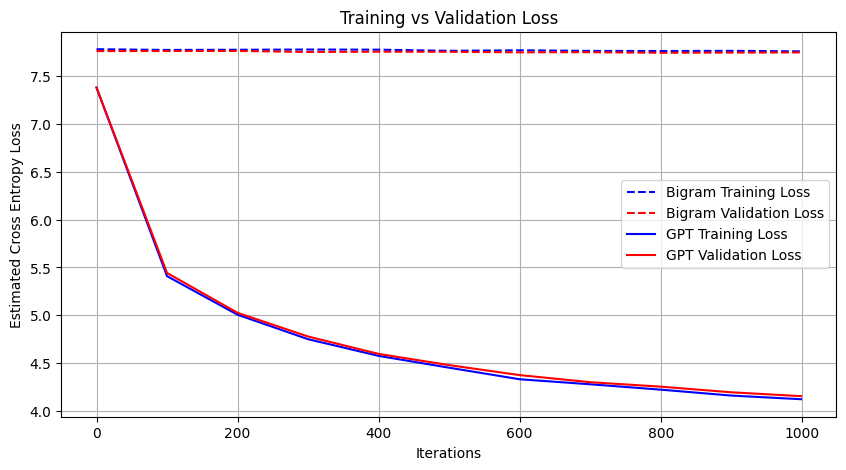

In [189]:
plt.figure(figsize=(10, 5))
plt.plot(bigram_iters, bigram_train_loss, label="Bigram Training Loss", color="blue", linestyle="--")
plt.plot(bigram_iters, bigram_val_loss, label="Bigram Validation Loss", color="red", linestyle="--")
plt.plot(gpt_iters, gpt_train_loss, label="GPT Training Loss", color="blue", linestyle="-")
plt.plot(gpt_iters, gpt_val_loss, label="GPT Validation Loss", color="red", linestyle="-")

# Labels and title
plt.xlabel("Iterations")
plt.ylabel("Estimated Cross Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()